In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *

In [ ]:
@cache_disk("full_hai")
def load_data():
    return read_fluxnet_csv(hai_path, None)

hai = load_data()

In [ ]:
model = KalmanFilter(n_dim_state = hai.shape[1], n_dim_obs=hai.shape[1])

more sensible default to the obs_cov

In [ ]:
model._set_constraint('obs_cov', model.obs_cov * 1e-1, train=True)

In [ ]:
model.obs_cov

tensor([[0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.1000]], grad_fn=<AddBackward0>)

In [ ]:
obs_cov_history = SaveParams('obs_cov')

In [ ]:
dls = make_dataloader(hai[:10_000], 200, 10, bs=10) 

In [ ]:
learn = Learner(dls, model, loss_func=imp_ll_loss, cbs=[obs_cov_history])

In [ ]:
learn.fit(10, 5e-3)

epoch,train_loss,valid_loss,time
0,37.007156,35.707901,00:42
1,23.424786,-2.581818,00:46
2,18.935411,-42.146591,00:45
3,-3.875268,-91.679558,00:45
4,-36.274509,-152.389908,00:45
5,-87.641487,-341.147583,00:50
6,-136.136597,-215.108154,00:46
7,-149.517105,-132.968475,00:50
8,-157.112869,-184.785660,00:50
9,-162.912567,-186.101288,00:45


/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/kalman/filter.py:193: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/kalman/filter.py:193: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/kalman/filter.py:193: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/kalman/filter.py:193: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")
/home/simone/Documents/uni/Thesis/GPFA_imputation/meteo_imp/kalman/filter.py:193: UserWarning: Matrix is not positive definite
  warn("Matrix is not positive definite")


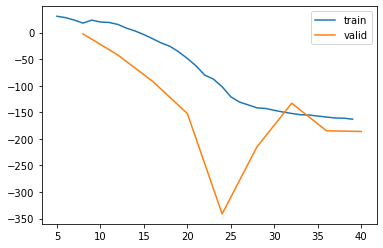

In [ ]:
learn.recorder.plot_loss()

In [ ]:
len(obs_cov_history.params)

50

In [ ]:
obs_cov_history.params[-1]

tensor([[ 0.0599, -0.0294, -0.0294],
        [-0.0294,  0.0598, -0.0292],
        [-0.0294, -0.0292,  0.0598]])

In [ ]:
is_posdef2(obs_cov_history.params[-1])

(True, tensor([0.0012, 0.0890, 0.0893]))

In [ ]:
posdef_log

""


In [ ]:
trained_state = learn.model.state_dict()

## Results

In [ ]:
from meteo_imp.data_preparation import MeteoDataTest
from meteo_imp.kalman.imputation import KalmanImputation

In [ ]:
def gap2res(var_sel, gap_len, gap_start, block_start=1000, block_end=1200):
    data = MeteoDataTest(hai.iloc[block_start:block_end, :]).add_gap(gap_len, var_sel, gap_start)
    imp = KalmanImputation(data.data)
    imp.model.filter.load_state_dict(trained_state)
    return imp.to_result(data.data_compl_tidy, var_names= data.data.columns, units=units, pred_all=True)

In [ ]:
data = MeteoDataTest(hai)

In [ ]:
var_sel = data.data.columns

In [ ]:
%time gap2res(var_sel, 10, 10)

CPU times: user 4.42 s, sys: 58.9 ms, total: 4.48 s
Wall time: 749 ms


Imputation Result:
        N obs: 200

In [ ]:
gaps = [2, 5, 7, 10, 20, 30, 50, 100]
gap_starts = [0, 30, 60, 90]

In [ ]:
from ipywidgets import interact_manual, IntSlider

In [ ]:
#| include: false
@interact_manual(TA=True,
                 SW_IN=True,
                 VPD=True,
                 gap_len=IntSlider(10, 1,100),
                 gap_start=IntSlider(30, 1,100),
                 block_start = IntSlider(1000, 0, 20_000, 1000),
                 block_len = IntSlider(200, 10, 1000, 10)
        )
def show_diff_gaps_res(TA, SW_IN, VPD, gap_len, gap_start, block_start, block_len):
    var_sel = []
    if TA: var_sel.append('TA')
    if SW_IN: var_sel.append('SW_IN')
    if VPD: var_sel.append('VPD')
    var_sel = (*var_sel,)
    gap2res(var_sel, gap_len, gap_start, block_start, block_start + block_len).display_results()
    

interactive(children=(Checkbox(value=True, description='TA'), Checkbox(value=True, description='SW_IN'), Check…